In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(1, 'src/')
import utilities
import config
import csv

from fastai import *
from fastai.text import *

In [2]:
# import data
SARC_DATA = config.SARC_DATA
SARC_MAIN = config.SARC_MAIN
SARC_POL = config.SARC_POL

train_path = SARC_MAIN + 'train-balanced.csv'
test_path = SARC_MAIN + 'test-balanced.csv'
comment_path = SARC_MAIN + 'comments.json'

train_docs, test_docs, train_labels, test_labels = \
    utilities.load_sarc_responses(train_path, test_path, comment_path)

In [3]:
print(train_docs.keys())

dict_keys(['ancestors', 'responses'])


In [4]:
len(train_docs['ancestors']), len(train_docs['responses'])

(128541, 128541)

In [5]:
# Create csv data file in format for training
learn_data = []

for index, label in enumerate(train_labels):
    ancestor = train_docs['ancestors'][index][0]
    response1 = train_docs['responses'][index][0]
    response2 = train_docs['responses'][index][1]
    label1 = label[0]
    label2 = label[1]
    learn_data.append([label1, ancestor + ' - ' + response1])
    learn_data.append([label2, ancestor + ' - ' + response2])

with open('bunch_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(learn_data)

In [6]:
bs=48

In [7]:
torch.cuda.set_device(0)

In [8]:
# Load databunch for lm training
ml_bunch = TextLMDataBunch.from_csv(path='.', csv_name='bunch_data.csv')

In [9]:
len(ml_bunch.vocab.itos),len(ml_bunch.train_ds)


(60000, 205664)

In [10]:
ml_bunch.show_batch()

idx,text
0,"- 0 xxmaj scotland ) - there 's nothing more that says "" fck you "" than scoring in a friendly . xxbos xxmaj principal blocks emergency exit to protect her xxmaj jeep - xxmaj man ... there 's even a xxmaj jeep - only parking spot right next to it ! xxbos xxmaj not the xxmaj president 's xxmaj fault , xxmaj but xxmaj exactly xxmaj what xxmaj he"
1,israelis - xxmaj israel should just seize the money . xxbos xxup nfl fans deserve better than xxmaj phil xxmaj simms at the xxmaj super xxmaj bowl - xxup gus xxup johnson xxup or xxup riot . xxbos xxmaj did we suddenly learn how to drive in the rain ? - xxmaj all those damn transplants with their rainy condition driving skills ! xxbos rb26dett xxmaj ford xxmaj transit van
2,") are creepy pedophiles . xxbos xxmaj week 10 xxmaj unpopular xxmaj opinion xxmaj thread - xxmaj reception rules are not actually that difficult to understand / judge , people just get confused when refs get them wrong xxbos xxmaj well that did not go well . - i hear wedding bells ! xxbos "" xxmaj why would n't this game give me fucking arrows "" -arin - xxmaj you"
3,"completely unbearable . xxbos xxmaj do you sometimes find yourself imagining what your life would be like if you were born the opposite gender ? - xxmaj for the same skills , position , and education , i 'll get a lower salary . xxbos xxmaj they 'll fuck you up - xxmaj repost xxbos i decided to open my schools computers - xxmaj glorious ssd masterrace xxbos xxmaj my"
4,"? xxbos xxup nvda suicide thread - xxmaj thanks , i needed this right now xxbos xxmaj former xxmaj manchester xxmaj united player , xxmaj park xxmaj ji - sung , is now at university in xxmaj leicester . - xxmaj ca n't wait to see him in xxmaj mosh and take him for a nandos xxbos xxmaj islamist threatens to attack xxmaj germany , xxmaj merkel : paper -"


In [11]:
# Save databunch
ml_bunch.save('lm_databunch')


/home/gaetano/anaconda3/envs/sarc/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [12]:
# load databunch
data_lm = load_data('.', 'lm_databunch', bs=bs)


In [13]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [14]:
wiki103 = pickle.load(open('wt103-fwd/itos_wt103.pkl', 'rb'))


In [15]:
vocab = data_lm.vocab

In [16]:
vocab.stoi['stingray']

16618

In [17]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


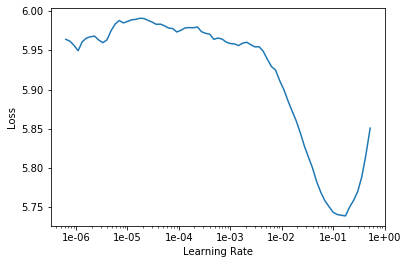

In [18]:
learn_lm.recorder.plot(skip_end=15)

In [19]:
lr = 2e-2
lr *= bs/48

In [20]:
learn_lm.to_fp16()


LanguageLearner(data=TextLMDataBunch;

Train: LabelList (205664 items)
x: LMTextList
xxbos xxmaj sheriff xxmaj joe xxmaj arpaio says he is still investigating xxmaj obama 's birth certificate - xxmaj thank god someone is still investigating .,xxbos xxmaj texts from my stalkerish ex after he decided i left him for someone else . - xxmaj at least he was original , pinky pic instead of dick pic,xxbos xxup o. xxmaj giroud goal vs xxmaj scotland ( xxmaj france 2 - 0 xxmaj scotland ) - there 's nothing more that says " fck you " than scoring in a friendly .,xxbos xxmaj principal blocks emergency exit to protect her xxmaj jeep - xxmaj man ... there 's even a xxmaj jeep - only parking spot right next to it !,xxbos xxmaj not the xxmaj president 's xxmaj fault , xxmaj but xxmaj exactly xxmaj what xxmaj he xxmaj wanted - that title sounds like trump wrote it .
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (51417 items)
x: LMTextList
xxbos springtrap in xxmaj vent | xxmaj blender xxmaj render - x

In [21]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8, 0.7))

In [22]:
learn_lm.unfreeze()

In [23]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

In [24]:
learn_lm.save('fine_tuned')
learn_lm.save_encoder('fine_tuned_enc')

In [26]:
learn_lm.load('fine_tuned')
